## Import Libraries and the Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from IPython.core.display import HTML
from statsmodels.formula.api import ols

In [2]:
# import the data set
kchd_df = pd.read_csv('kc_house_data.csv')

## Exploratory Data Analysis and Data Set Cleaning

The following utility function simply allows us to print multiple Pandas DataDrames with "pretty" (HTML) formatting, using the Python `print()` function.

We will use it throughout this notebook whenever we wish to display a DataFrame.

For now, we use it to get an intuitive initial feel for the data set.

In [3]:
# this function allows displaying dataframes using print() with pandas "pretty" HTML formatting
#   so that multiple "pretty" displays of dataframes can be rendered "inline"
#   default behavior (without specifying a range) is identical to that of df.head()
def print_df(df, r = None):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', -1)

    if r is None:
        r = range(0, len(df))
    display(HTML(df.iloc[r].to_html()))
    display(HTML("<br>{} rows x {} columns<br><br>".format(len(r), len(df.columns))))

    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def print_df_head(df):
    print_df(df, range(0,5))    

print_df_head(kchd_df)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We noticed right off the bat that there is a null (`NaN`) value in the very first row.

### Null Values

We officially begin our *EDA* phase by cleaning null values in the data set.

The `cols_with_null_vals` function provides a summary of all features in our data set that have null values.

In [4]:
# note that we can qualitatively retrieve this information via df.info() but this function
#   provides us with an object we can manipulate programatically, whereas df.info() just 
#   prints the display of this information
def cols_with_nulls(df):
    cols_with_null_vals = []
    summary_cols = ['name', 'index', 'dtype', 'n_null']
    for idx, col in enumerate(df.columns):
        n_null = df[col].isna().sum()
        if n_null > 0:
            cols_with_null_vals.append([col, idx, df[col].dtype, n_null])
    return pd.DataFrame(cols_with_null_vals, columns=summary_cols)

kchd_cwnv_df = cols_with_nulls(kchd_df)
display(HTML("<b>Columns with null values:</b><br><br>"))
print_df(kchd_cwnv_df)

,name,index,dtype,n_null
0,waterfront,8,float64,2376
1,view,9,float64,63
2,yr_renovated,15,float64,3842


We are working our way toward cleaning these null values.  As part of the process, after having identified which features need to be cleaned of null values, we must decide on a strategy for clearning this data.  One of the "Golden Rules" in Data Science is to avoid dropping observations from our data set at all costs and is only to be used as a last resort.  So, we decide early that we will do absolutely no dropping of any observations containing null values whatsoever.  We opt to adopt a null-value *replacement* scheme.  But, we need some heuristic to decide target values which will replace nulls that makes sense.  Understanding the data better for each of these features should suggest an acceptable replacement heuristic.

To do this, we investigate the unique values of the above features, and whether those features are *continuous* or *categorical*.

### Unique Values and Categorical "Classification"

For **continuous** data, we ought to use some aggregate function which retains the existing central tendency of the *good* values in our data set - i.e. depending on the presence of outliers or not, in the case of continuous data, we would opt to replace with the *median* or *mean* of the good values, respectively.

For **categorical** (or discrete) data, we would replace with a target discrete value or set of discrete values.  But which discrete value?  Well, this is where categorical classification comes in.  If we can determine, with a high probability, that our data is categorical, then we need to inspect the meaning of the categorical values in order to properly choose which target value should replace a null value.

So, let's take a look that now.

The following function derives a probability that a given feature is categorical or not based on the ratio of unique values to the total number of observations.  If this ratio is very low, then it suffices to say that the probability is high that the feature is likely categorical.

In [5]:
def categorical_probability(df, col, exclude_null_vals=True):
    unique_vals = df[col].unique()
    n_unique = len(unique_vals) 
    if exclude_null_vals:
        if df[col].dtype is int or df[col].dtype is float or df[col].dtype is np.float64:
            unique_vals_without_null = unique_vals[~np.isnan(unique_vals)]
        else:
            unique_vals_without_null = unique_vals[~pd.isnull(unique_vals)]
        if len(unique_vals_without_null) < len(unique_vals):
            unique_vals = unique_vals_without_null
            n_unique -= 1
    unique_vals = sorted(unique_vals)
    return (n_unique, round(1 - (n_unique/(len(df[col]))), 4), unique_vals)

And then the next function wraps the above function to get a feel of whether the probabilities that features in the data as a whole are categorical, based on some threshold.

In [6]:
def classify_as_categorical(df, threshold, exclude_null_vals=True):
    cols_classified = []
    summary_cols = ['name', 'index', 'dtype', 'n_unique', 'p_cat', 'unique_vals']
    for idx, col in enumerate(df.columns):
        n_unique, p_cat, unique_vals = categorical_probability(df, col, exclude_null_vals)
        if p_cat >= threshold:
            cols_classified.append([col, idx, df[col].dtype, n_unique, p_cat, unique_vals])
    return pd.DataFrame(cols_classified, columns=summary_cols)

Let's use it now to help determine our replacement heuristic for the **waterfront**, **view**, and **yr_renovated** features.

In [7]:
threshold = 0.0
kchd__nulls_with_cat_classification_df = classify_as_categorical(kchd_df[kchd_cwnv_df['name']], threshold)
display(HTML("<b>Columns with null values, categorical probability classification:</b><br><br>".format(threshold)))
print_df(kchd__nulls_with_cat_classification_df)

,name,index,dtype,n_unique,p_cat,unique_vals
0,waterfront,0,float64,2,0.9999,"[0.0, 1.0]"
1,view,1,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"
2,yr_renovated,2,float64,70,0.9968,"[0.0, 1934.0, 1940.0, 1944.0, 1945.0, 1946.0, 1948.0, 1950.0, 1951.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1962.0, 1963.0, 1964.0, 1965.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0]"


As you can see, the probability that each of the above features is categorical is VERY HIGH!  This is consistent with the actual list of unique values for each (excluding null).

This gives an indication that we can use a *lteral-value replacement heuristic* when we clean this data.

We can see that:
- **waterfront** behaves as a *Boolean* value and that a null value can safely be replaced by 0.0
- **view** ranges from 0 to 4: here we must decide which of these values makes most sense to use as a replacement for null
    - 0 could mean no view but
    - so that we do not disrupt the central tendency, we could use the median value, 2.0
    - on the other hand, we could be unintentionally "un-skewing" this feature if the original intent of a null value was meant to be treated equivalent to value 0.0
    - in order to counter-act undesired skewing of the data, we opt to treat null values as equivalent to value 0.0
- **yr_renovated** clearly uses 0.0 to indicate that a home has not been renovated; so we will adopt the heuristic to replace null with 0.0 in this case

Since we have decided on the heuristics for all features with null values, we can clean those features now.

The function below was written to facilitate cleaning the data based on a text-based rule definition.  See the documentation preceding the function as comments for its usage.

In [8]:
# numeric_replacement_rules should be of the form:
#    {<name_of_col>: [(outlier_val_1, 'median'|'mean'|<numeric_replacement_value>), ((outlier_val_2, 'median'|'mean'|<numeric_replacement_value>)), ... , (outlier_val_n, 'median'|'mean'|<numeric_replacement_value>)]}}
def clean_offending_values(df, numeric_replacement_rules = None, string_replacement_rules = None, friendly_name_of_df = ""):
    friendly_name = friendly_name_of_df if len(friendly_name_of_df) > 0 else "df"
    print("*** CLEANING VALUES of {}: BEGIN ***\n".format(friendly_name))
    
    has_numeric_rules = numeric_replacement_rules is not None
    has_string_rules = string_replacement_rules is not None

    if has_numeric_rules or has_string_rules:

        if has_numeric_rules:
            for col, rules in numeric_replacement_rules.items():
                print("Rules for '{}' column value replacement are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    # now handle specific replacement rule - we only have three allowable: median, mean, or a constant value
                    # if the rule is a constant value, then we can replace in place
                    data_type = type(rule)
                    replace_with_numeric_literal = data_type is int or data_type is float or data_type is np.float64
                    replace_with_median = data_type is str and rule.lower() == 'median'
                    replace_with_min = data_type is str and rule.lower() == 'min'
                    replace_with_max = data_type is str and rule.lower() == 'max'
                    replace_with_mean = data_type is str and rule.lower() == 'mean'
                    if replace_with_numeric_literal:
                        df.loc[offending_indexes, col] = rule
                        print("Replaced {} offending instances in column '{}' with literal value {}\n".format(len(offending_indexes), col, rule))
                    elif replace_with_median or replace_with_min or replace_with_max or replace_with_mean:
                        # first we need to get a subset of the rows WITHOUT any of the offending values
                        df_rows_without_outliers = df[df[col].isin(offending_vals)==False]
                        if replace_with_median or replace_with_min or replace_with_max:
                            unique_vals = sorted(df_rows_without_outliers[col].unique())
                            imputed = np.min(unique_vals) if replace_with_min else (np.min(unique_vals) if replace_with_max else np.median(unique_vals))
                            s_imputed_from = "unique values: {}".format(unique_vals)
                        else:
                            imputed = np.mean(df_rows_without_outliers[col])
                            s_imputed_from = "values from index domain:\n{}".format(df_rows_without_outliers.index) 
                        df.loc[offending_indexes, col] = imputed 
                        s_desc = "the {} of column '{}'".format(rule, col)  
                        print("{} is {} and was imputed from {}".format(s_desc.capitalize(), imputed, s_imputed_from))
                        print("Replaced {} offending instances in column '{}' with {} ({})\n".format(len(offending_indexes), col, s_desc, imputed))
                    else:
                        print("Unsupported or unknown rule: {}".format(rule))                   
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

        if has_string_rules:
            for col, rules in string_replacement_rules.items():
                print("Rules for '{}' are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values in {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    df.loc[offending_indexes, col] = rule
                    print("Replaced {} offending instances in column '{}' with literal value '{}'\n".format(len(offending_indexes), col, rule))                 
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

    else:
        print("Cannot clean outliers from {} since there were no replacement rules provided!".format(friendly_name))
    
    print("*** CLEANING VALUES of {}: END ***".format(friendly_name))

In [9]:
# now use the above function to clean 'waterfront' and 'yr_renovated' using lteral-value replacement
clean_offending_values(
    kchd_df
    , numeric_replacement_rules=
        {
            'waterfront': [(np.NaN, 0.0)]
            , 'view': [(np.NaN, 0.0)]
            , 'yr_renovated': [(np.NaN, 0.0)]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'waterfront' column value replacement are: [(nan, 0.0)]
Looking for rows with 'waterfront' values [nan] ...
Rows with offending values occur at Int64Index([    0,    10,    23,    40,    55,    60,    62,    66,    87,
              105,
            ...
            21544, 21545, 21550, 21562, 21567, 21578, 21582, 21586, 21587,
            21595],
           dtype='int64', length=2376).
Replaced 2376 offending instances in column 'waterfront' with literal value 0.0

Rules for 'view' column value replacement are: [(nan, 0.0)]
Looking for rows with 'view' values [nan] ...
Rows with offending values occur at Int64Index([    7,   114,   129,   205,   487,   590,   938,  1313,  1364,
             1701,  2415,  2833,  3150,  3237,  4533,  4740,  5196,  5207,
             5393,  5494,  5585,  5746,  6391,  7103,  7269,  7563,  7686,
             7716,  8047,  8066,  8279,  8575,  9405,  9853, 10023, 10174,
            1033

Having dealt with features with null values, we can now turn our attention to identifying and handling any potential outlier values.

### Deal with any potential OUTLIER (peculiar) values

We can leverage our `classify_as_categorical` function to list unique values of every feature in our data set.

If we spot any peculiar values we can then deal with them as necessary.

In [10]:
# Let's look for outliers
threshold = 0.0
kchd_cat_classification_df = classify_as_categorical(kchd_df[kchd_df.columns[1:]], threshold, False)
display(HTML("<b>Columns with potentical OUTLIER values:</b><br><br>".format(threshold)))
print_df(kchd_cat_classification_df[['name', 'dtype', 'n_unique', 'p_cat', 'unique_vals']].set_index('name'))

,dtype,n_unique,p_cat,unique_vals
name,,,,
date,object,372,0.9828,"[1/10/2015, 1/12/2015, 1/13/2015, 1/14/2015, 1/15/2015, 1/16/2015, 1/17/2015, 1/19/2015, 1/2/2015, 1/20/2015, 1/21/2015, 1/22/2015, 1/23/2015, 1/24/2015, 1/25/2015, 1/26/2015, 1/27/2015, 1/28/2015, 1/29/2015, 1/30/2015, 1/31/2015, 1/5/2015, 1/6/2015, 1/7/2015, 1/8/2015, 1/9/2015, 10/1/2014, 10/10/2014, 10/11/2014, 10/12/2014, 10/13/2014, 10/14/2014, 10/15/2014, 10/16/2014, 10/17/2014, 10/18/2014, 10/19/2014, 10/2/2014, 10/20/2014, 10/21/2014, 10/22/2014, 10/23/2014, 10/24/2014, 10/25/2014, 10/26/2014, 10/27/2014, 10/28/2014, 10/29/2014, 10/3/2014, 10/30/2014, 10/31/2014, 10/4/2014, 10/5/2014, 10/6/2014, 10/7/2014, 10/8/2014, 10/9/2014, 11/1/2014, 11/10/2014, 11/11/2014, 11/12/2014, 11/13/2014, 11/14/2014, 11/15/2014, 11/16/2014, 11/17/2014, 11/18/2014, 11/19/2014, 11/2/2014, 11/20/2014, 11/21/2014, 11/22/2014, 11/23/2014, 11/24/2014, 11/25/2014, 11/26/2014, 11/28/2014, 11/29/2014, 11/3/2014, 11/30/2014, 11/4/2014, 11/5/2014, 11/6/2014, 11/7/2014, 11/8/2014, 11/9/2014, 12/1/2014, 12/10/2014, 12/11/2014, 12/12/2014, 12/13/2014, 12/14/2014, 12/15/2014, 12/16/2014, 12/17/2014, 12/18/2014, 12/19/2014, 12/2/2014, 12/20/2014, 12/21/2014, ...]"
price,float64,3622,0.8323,"[78000.0, 80000.0, 81000.0, 82000.0, 82500.0, 83000.0, 84000.0, 85000.0, 86500.0, 89000.0, 89950.0, 90000.0, 92000.0, 95000.0, 96500.0, 99000.0, 100000.0, 102500.0, 104950.0, 105000.0, 105500.0, 106000.0, 107000.0, 109000.0, 109500.0, 110000.0, 110700.0, 111300.0, 112000.0, 114000.0, 114975.0, 115000.0, 118000.0, 118125.0, 119500.0, 119900.0, 120000.0, 120750.0, 121800.0, 122000.0, 123000.0, 123300.0, 124000.0, 124500.0, 124740.0, 125000.0, 126000.0, 126500.0, 128000.0, 128750.0, 129000.0, 129888.0, 130000.0, 132500.0, 132825.0, 133000.0, 133400.0, 134000.0, 135000.0, 135900.0, 136500.0, 137000.0, 137124.0, 137900.0, 139000.0, 139500.0, 140000.0, 141800.0, 142500.0, 143000.0, 144000.0, 144975.0, 145000.0, 145600.0, 146000.0, 146300.0, 147000.0, 147200.0, 147400.0, 147500.0, 148000.0, 148226.0, 148900.0, 149000.0, 149500.0, 149900.0, 150000.0, 150550.0, 151000.0, 151100.0, 151600.0, 152000.0, 152275.0, 152500.0, 152900.0, 153000.0, 153500.0, 153503.0, 154000.0, 154200.0, ...]"
bedrooms,int64,12,0.9994,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33]"
bathrooms,float64,29,0.9987,"[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]"
sqft_living,int64,1034,0.9521,"[370, 380, 390, 410, 420, 430, 440, 460, 470, 480, 490, 500, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 809, 810, 820, 828, 830, 833, 840, 850, 860, 870, 880, 890, 893, 894, 900, 901, 902, 910, 920, 930, 940, 950, 960, 962, 970, 980, 982, 988, 990, 998, 1000, 1008, 1010, 1020, 1030, 1040, 1048, 1050, 1060, 1061, 1068, 1070, 1072, 1076, 1078, 1080, 1084, 1088, 1090, 1092, 1095, 1100, 1108, 1110, 1120, 1122, 1129, 1130, 1131, ...]"
sqft_lot,int64,9776,0.5473,"[520, 572, 600, 609, 635, 638, 649, 651, 675, 676, 681, 683, 690, 696, 698, 700, 704, 705, 711, 713, 720, 725, 736, 740, 745, 746, 747, 750, 758, 761, 762, 772, 779, 780, 785, 798, 800, 801, 804, 806, 809, 811, 812, 813, 814, 816, 819, 825, 826, 833, 834, 835, 844, 846, 847, 850, 851, 853, 857, 858, 863, 864, 865, 867, 868, 871, 873, 874, 875, 877, 881, 885, 886, 887, 889, 890, 892, 895, 900, 902, 904, 905, 907, 912, 913, 914, 915, 916, 920, 922, 923, 925, 926, 929, 930, 932, 934, 936, 937, 940, ...]"
floors,float64,6,0.9997,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]"
waterfront,float64,2,0.9999,"[0.0, 1.0]"
view,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"


Based on the above, we do spot two specific issues:

1. based on *unique_vals* of **bedrooms**, it has an *apparent* OUTLIER value: 33.
2. based on *unique_vals* and *dtype* of **sqft_basement**, it looks like it should be a *numeric* data type but it is of type `Object` (probably stored as text).

Let's address **sqft_basement** first.

#### Converting **sqft_basement** from `string` type to `float`

Before attempting to convert the data type of **sqft_basement** to `float`, we need to replace any potential non-numeric values.

Let's find those first.

In [11]:
unique_sqft_basement = kchd_cat_classification_df[kchd_cat_classification_df['name']=='sqft_basement']['unique_vals'].values[0]
non_numeric_sqft_basement_vals = []
for idx, sqft_basement in enumerate(unique_sqft_basement):
    s_val = sqft_basement.strip()
    val = None
    try:       
        val = float(s_val)
    except:
        non_numeric_sqft_basement_vals.append(sqft_basement)

display(HTML("<b>sqft_basement</b> contains the following non-numeric values that must be replaced: {}".format(non_numeric_sqft_basement_vals)))

We opt to replace outlier value '?' of the **sqft_basement** feature with '0.0' *before* we finally convert it from `str` to `float`.

In [12]:
clean_offending_values(
    kchd_df
    , string_replacement_rules=
        {
            'sqft_basement': [('?', '0.0')]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' are: [('?', '0.0')]
Looking for rows with 'sqft_basement' values in ['?'] ...
Rows with offending values occur at Int64Index([    6,    18,    42,    79,   112,   115,   217,   309,   384,
              508,
            ...
            21236, 21248, 21356, 21357, 21365, 21442, 21447, 21473, 21519,
            21581],
           dtype='int64', length=454).
Replaced 454 offending instances in column 'sqft_basement' with literal value '0.0'

*** CLEANING VALUES of King County House Sales DF: END ***


We can now convert **sqft_basement** to type `float`:

In [13]:
kchd_df['sqft_basement']=kchd_df['sqft_basement'].astype('float64')

#### Handling **bedrooms** outliers

In [14]:
outlier_rooms = 33
kchd_with_outlier_rooms_df = kchd_df[kchd_df['bedrooms']==outlier_rooms]
kchd_with_outlier_rooms_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


Here, we see that there are home(s) that supposedly have 33 bedrooms.  Really?  I don't think so but let's try to justify this mathematically.

We see that the value of **sqft_living** is only 1620.

Let's compute the average square footage per room and compare its value to the average square footage per room of the entire data set, excluding this possible outlier observation, with **bedrooms**==33.

In [15]:
outlier_rms_avg_sqft_per_room = kchd_with_outlier_rooms_df['sqft_living']/outlier_rooms
outlier_rms_avg_sqft_per_room[outlier_rms_avg_sqft_per_room.index]

15856    49.090909
Name: sqft_living, dtype: float64

We see that, for the outlier, the average square footage per room is about 49 ft.$^2$.  That means, on average, each room is 7 ft. x 7 ft.  Is this likely?  Let's compare it to the average square footage per room of the entire data set, excluding this possible outlier observation with **bedrooms**==33.

In [16]:
avg_sqft_per_room_excluding_apparent_outlier = kchd_df['sqft_living'].sum()/kchd_df[kchd_df['bedrooms'].isin([outlier_rooms])==False]['bedrooms'].sum()
avg_sqft_per_room_excluding_apparent_outlier

617.0000686643413

We see that our outlier average square footage per room differs *drastically* from the average for the data set.  So we will impute the average (of the data set) to arrive at a reasonable value for **bedrooms** for the outlier.  Granted, this is only one observation and we have done a bit of work so far to clean this outlier value.  But, this process demonstrates the potential importance in the general case.

The formula for this is: $imputed\_outlier\_bedrooms = \frac{outlier\_sqft\_living}{avg\_sqft\_per\_room\_excluding\_apparent\_outlier}$.

In [17]:
imputed_outlier_bedrooms = kchd_with_outlier_rooms_df['sqft_living']/avg_sqft_per_room_excluding_apparent_outlier
imputed_outlier_bedrooms = imputed_outlier_bedrooms.values[0]
imputed_outlier_bedrooms

2.62560748738151

In [18]:
unique_bedrooms = sorted(list(kchd_df['bedrooms'].unique()))
unique_bedrooms.remove(outlier_rooms)
unique_bedrooms = np.array(unique_bedrooms)
print("Permissable values of bedrooms is: {}".format(unique_bedrooms))

Permissable values of bedrooms is: [ 1  2  3  4  5  6  7  8  9 10 11]


Since **imputed_outlier_bedrooms** $\in \mathbb{R}$, we need to match it to its closest neighbor in the range of *permissable* categorical values of **bedrooms**, \[1  2  3  4  5  6  7  8  9 10 11\].

In [19]:
idx_closest_br = -1
min_dist = -1
for idx, br in enumerate(unique_bedrooms):
    d = abs(imputed_outlier_bedrooms - br)
    if min_dist == -1:
        min_dist = d
        idx_closest_br = idx
    elif d < min_dist:
        min_dist = d
        idx_closest_br = idx

print("The closest (categorical) bedroom value to computed real-value {}, from {}, is {}, occuring at index {}.".format(imputed_outlier_bedrooms, unique_bedrooms, unique_bedrooms[idx_closest_br], idx_closest_br))
imputed_outlier_bedrooms = unique_bedrooms[idx_closest_br]

The closest (categorical) bedroom value to computed real-value 2.62560748738151, from [ 1  2  3  4  5  6  7  8  9 10 11], is 3, occuring at index 2.


Now we impute this value in the data set for all observations with the **bedrooms** outlier value, 33.

In [20]:
kchd_df.loc[kchd_with_outlier_rooms_df.index, 'bedrooms'] = imputed_outlier_bedrooms

Moving on...

### Categorization

Drawing from our observations from our original search for outliers, we see that **there are more features which are *apparently* categorical**.

We make this more explicit by again calling `classify_as_categorical`, but this time with a probability `threshold` value of 0.998 (based on the observations from our original search for outliers).

We use this value, again derived from observation of unique values of each feature, in order to separate apparent *categorical* features from *continuous* features.

In [21]:
threshold = 0.998
kchd_cat_classification_df = classify_as_categorical(kchd_df, threshold, False)
display(HTML("<b>Categorical Features (probability >= {}):</b><br><br>".format(threshold)))
print_df(kchd_cat_classification_df)

,name,index,dtype,n_unique,p_cat,unique_vals
0,bedrooms,3,int64,11,0.9995,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
1,bathrooms,4,float64,29,0.9987,"[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]"
2,floors,7,float64,6,0.9997,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]"
3,waterfront,8,float64,2,0.9999,"[0.0, 1.0]"
4,view,9,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,condition,10,int64,5,0.9998,"[1, 2, 3, 4, 5]"
6,grade,11,int64,11,0.9995,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"


Having cleaned our data set of null values and outliers, we are now ready to officially bin our categorical data.

#### Binning

From the above, we note that:
- **bathrooms** has a strange range of values, \[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0\], but we can handle this by appropriate binning into:
    - $16$ bins: [0, 0.5), [0.5, 1), [1, 1.5), [1.5, 2), [2, 2.5), [2.5, 3), [3, 3.5), [3.5, 4), [4, 4.5), [4.5, 5), [5, 5.5), [5.5, 6), [6, 6.5), [6.5, 7), [7, 7.5), [7.5, 8)
    - we bin in increments of 0.5 since, according to the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) in this data set, **bathrooms** is "Number of bathrooms, where .5 accounts for a room with a toilet but not shower"
- **floors** has a strange range of values, \[1.0, 1.5, 2.0, 2.5, 3.0, 3.5\], which we also handle by appropriate binning:
    - $4$ bins: [0, 1), [1, 2), [2, 3), [3, 4)
    - we do this since we are not given a definition of what a *fractional* floor is, according to the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices)
- for all other categorical features from the list above, since the count of categorical values is low, we simply create partitions according to the *cardinality* of the set of categorical values of each

Note:<br>
For the **bathrooms** categorical feature, we could have addressed the values with 0.25 and 0.75 components in the cleaning phase via a *rounding* replacement heuristic but then we would have had to decide whether either should round up or down, to the nearest 0.5 increment.  *Binning* effectively accomplishes the same and with less work (since we have to do binning anyway).  Additionally, by binning in increments of 0.5, we adhere close to the definition of **bathrooms** listed in the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices).  **We are interested in observing the impact that adding additional bathrooms *with and without a shower* has on potential sale price**.

In [22]:
def partition(df, feature, bins=None):
    if bins is None:
        bins = list(df[feature].unique())
    bins.append(min(bins)-1)
    bins = sorted(bins)
    #print("{} bins list: {}".format(feature, bins))
    bins_feature = pd.cut(df[feature], bins)
    bins_feature = bins_feature.cat.as_unordered()
    #print("{} bins:\n{}".format(feature, bins_feature))
    return bins_feature

def categorize(df, feature, bins=None):
    bins_feature = partition(df, feature, bins)
    feature_dummy = pd.get_dummies(bins_feature, prefix=feature, drop_first=True)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, feature_dummy], axis=1)
    return df

In [23]:
# before we categorize features, let's store the list of continuous features 
# we opt to do this now since categorization drops the original non-categorized manifestation
# of the above categorizal features
# doing it this way just makes it more convenient for when we need this list for scaling/normalization/transformation
categorical_features = list(kchd_cat_classification_df['name'])
continuous_features = list(kchd_df.columns)
for cat_feat in categorical_features:
    continuous_features.remove(cat_feat)
continuous_features.remove('id')

In [24]:
kchd_df = categorize(kchd_df, 'bedrooms')
kchd_df = categorize(kchd_df, 'bathrooms', [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])
kchd_df = categorize(kchd_df, 'floors', [1, 2, 3, 4])
kchd_df = categorize(kchd_df, 'waterfront')
kchd_df = categorize(kchd_df, 'view')
kchd_df = categorize(kchd_df, 'condition')
kchd_df = categorize(kchd_df, 'grade')

kchd_df.head()

,id,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,...,"grade_(3, 4]","grade_(4, 5]","grade_(5, 6]","grade_(6, 7]","grade_(7, 8]","grade_(8, 9]","grade_(9, 10]","grade_(10, 11]","grade_(11, 12]","grade_(12, 13]"
0,7129300520,10/13/2014,221900.0,1180,5650,1180,0.0,1955,0.0,98178,...,0,0,0,1,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,2570,7242,2170,400.0,1951,1991.0,98125,...,0,0,0,1,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,770,10000,770,0.0,1933,0.0,98028,...,0,0,1,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,1960,5000,1050,910.0,1965,0.0,98136,...,0,0,0,1,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,1680,8080,1680,0.0,1987,0.0,98074,...,0,0,0,0,1,0,0,0,0,0


### Feature Scaling, Normalization, and Transformation

Before we begin, let's have a look at the bounds we have for *continuous* each feature.

In [25]:
def plot_corr(df, filter=None):
    corr = df[filter].corr() if (filter is not None and len(filter) > 0) else df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

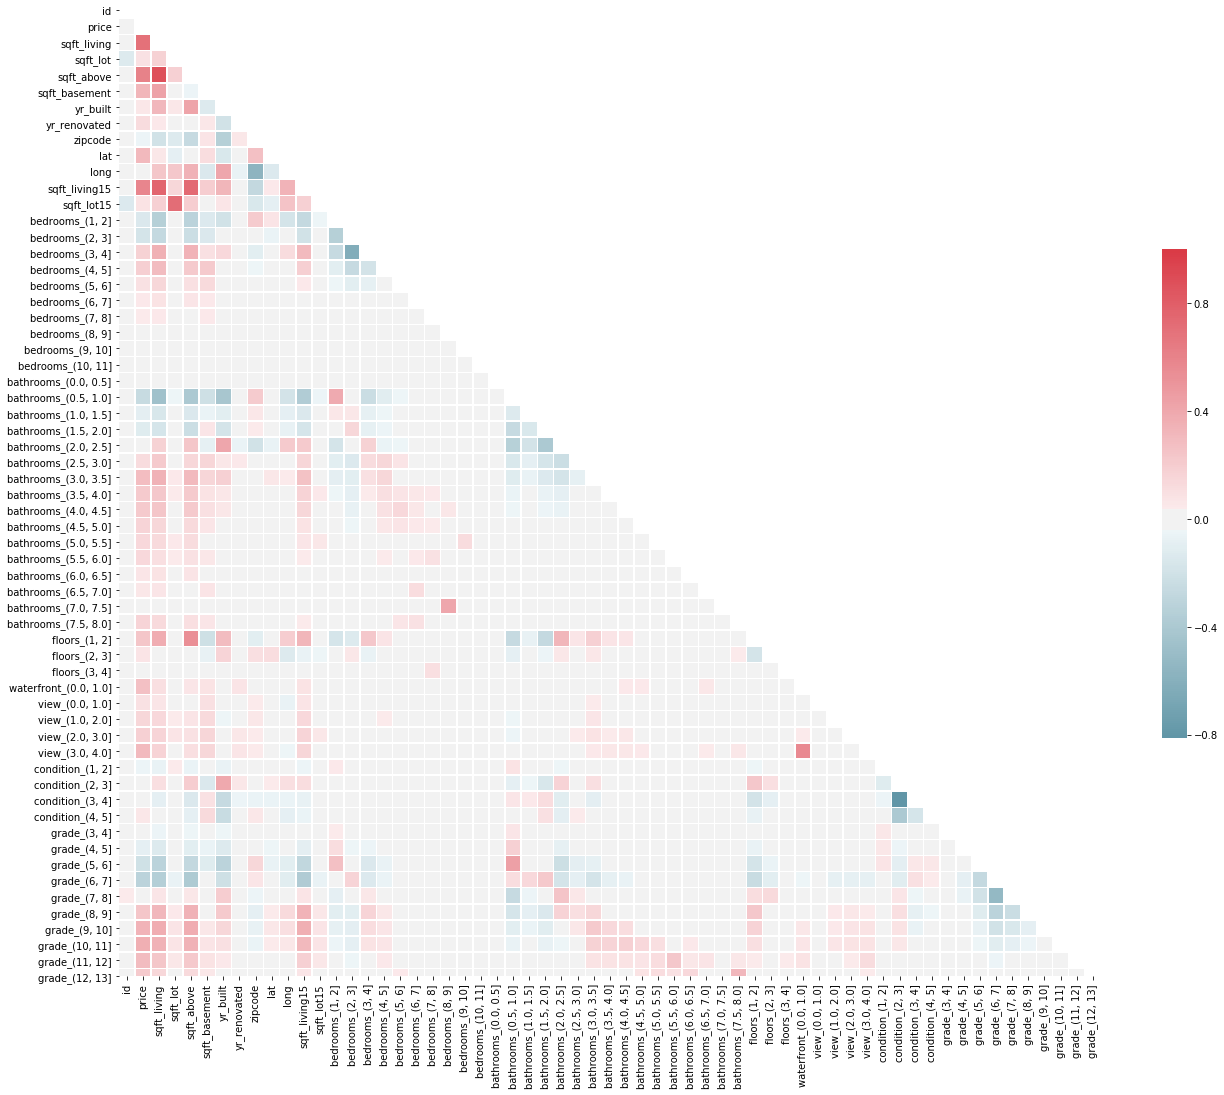

In [26]:
plot_corr(kchd_df)

In [27]:
bounds_map = dict()
continuous_features.remove('date')
continuous_features.remove('price')
for feature in continuous_features:
    bounds_map[feature] = (kchd_df[feature].dtype, kchd_df[feature].min(), kchd_df[feature].max())
bounds_map

{'sqft_living': (dtype('int64'), 370, 13540),
 'sqft_lot': (dtype('int64'), 520, 1651359),
 'sqft_above': (dtype('int64'), 370, 9410),
 'sqft_basement': (dtype('float64'), 0.0, 4820.0),
 'yr_built': (dtype('int64'), 1900, 2015),
 'yr_renovated': (dtype('float64'), 0.0, 2015.0),
 'zipcode': (dtype('int64'), 98001, 98199),
 'lat': (dtype('float64'), 47.1559, 47.7776),
 'long': (dtype('float64'), -122.51899999999999, -121.315),
 'sqft_living15': (dtype('int64'), 399, 6210),
 'sqft_lot15': (dtype('int64'), 651, 871200)}

It is clear that all continuous candidate features need to be scaled.  

Now have a look at the distributions of each for some insight into whether or not we should log-transform a given feature.

In [28]:
def histograms(df, filter=None):
    r_w = 20
    r_h = 4
    c_n = 4
    r_n = len(df.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)
    unused = list(range(0, len(axes.flatten())))

    included_vars = []
    cols = filter if (filter is not None and len(filter) > 0) else df.columns
    for index, variable in enumerate(cols):
        ax = fig.add_subplot(r_n, c_n, index+1)
        df[variable].hist(ax=ax)
        plt.xlabel(variable)
        included_vars.append(variable)
        unused.remove(index)

    flattened_axes = axes.flatten()
    for u in unused:
        fig.delaxes(flattened_axes[u])

    return included_vars

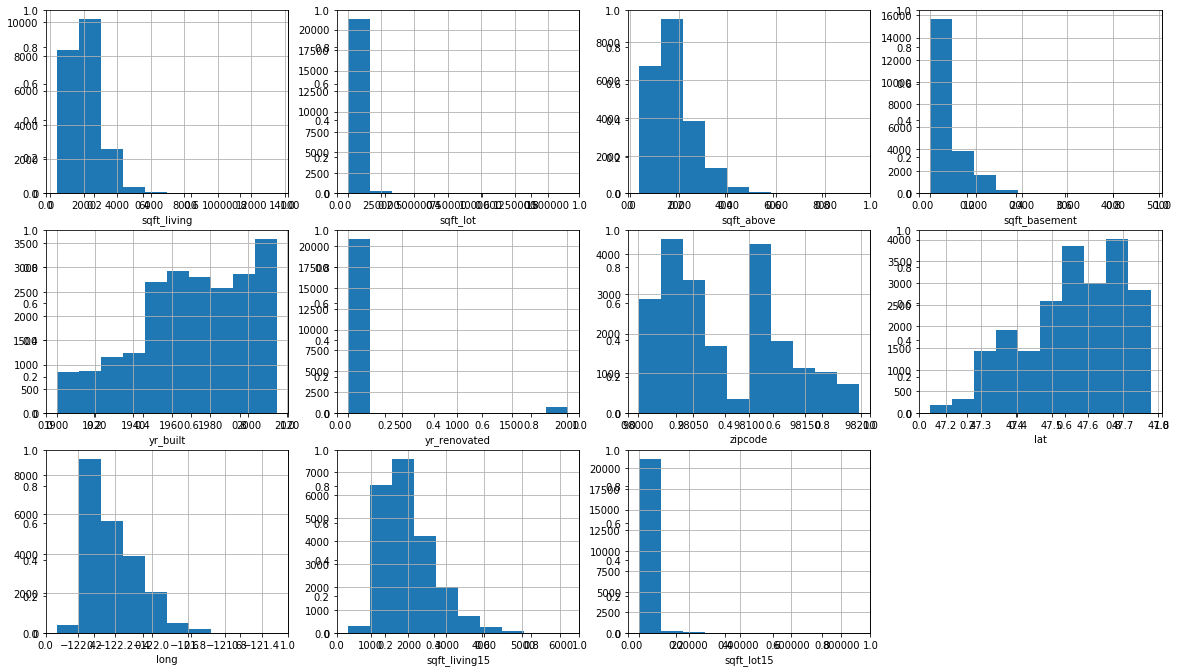

In [29]:
histograms(kchd_df, continuous_features);

From the visuals of the above candidate continuous features, we see that all need to be scaled and also the the following features must be log-transformed in order to push their distributions more toward normal:
- **sqft_living**
- **sqft_above**
- **sqft_basement**
- **yr_built**
- **zipcode**
- **lat**
- **long**
- **sqft_living15**

But we must pay careful attention to features with values $\le 0$ since this will preclude doing log-transformations.  **sqft_basement** is one such feature.

So we replace all instances of 0.0 with 0.0001 in order to make log-transformation possible.

In [30]:
clean_offending_values(
    kchd_df
    , numeric_replacement_rules=
        {
            'sqft_basement': [(0.0, 0.0001)]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' column value replacement are: [(0.0, 0.0001)]
Looking for rows with 'sqft_basement' values [0.0] ...
Rows with offending values occur at Int64Index([    0,     2,     4,     6,     7,     9,    12,    13,    14,
               16,
            ...
            21585, 21586, 21587, 21588, 21589, 21592, 21593, 21594, 21595,
            21596],
           dtype='int64', length=13280).
Replaced 13280 offending instances in column 'sqft_basement' with literal value 0.0001

*** CLEANING VALUES of King County House Sales DF: END ***


In [31]:
def log_transform(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        df[feat] = df[feat].map(lambda v: np.log(v))
    return df

# Min-max scaling: this will not be particularly useful to us in this case since this way of scaling brings values between 0 and 1
def min_max_scaling(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-min_feat)/(max_feat-min_feat))
    return df

# standardization does not make data  moremore  normal, it will just change the mean and the standard error!
def standardization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        sqr_var_feat = np.sqrt(np.var(df[feat]))
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/sqr_var_feat)
    return df

# The distribution will have values between -1 and 1, and a mean of 0.
def mean_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/(max_feat-min_feat))
    return df    

# Unit vector transformation
def unit_vector_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        norm_feat = np.sqrt((df[feat]**2).sum())
        df[feat] = df[feat].map(lambda x: x/norm_feat)
    return df 

In [32]:
tf = ['sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_basement']
kchd_df = min_max_scaling(log_transform(kchd_df, tf), tf)

tf = ['yr_built', 'zipcode', 'lat', 'long', 'yr_renovated']
kchd_df = min_max_scaling(kchd_df, tf)

for feature in continuous_features:
    bounds_map[feature] = (kchd_df[feature].dtype, kchd_df[feature].min(), kchd_df[feature].max())
bounds_map

{'sqft_living': (dtype('float64'), 0.0, 1.0),
 'sqft_lot': (dtype('float64'), 0.0, 1.0),
 'sqft_above': (dtype('float64'), 0.0, 1.0),
 'sqft_basement': (dtype('float64'), 0.0, 1.0),
 'yr_built': (dtype('float64'), 0.0, 1.0),
 'yr_renovated': (dtype('float64'), 0.0, 1.0),
 'zipcode': (dtype('float64'), 0.0, 1.0),
 'lat': (dtype('float64'), 0.0, 1.0),
 'long': (dtype('float64'), 0.0, 1.0),
 'sqft_living15': (dtype('float64'), 0.0, 1.0),
 'sqft_lot15': (dtype('float64'), 0.0, 1.0)}

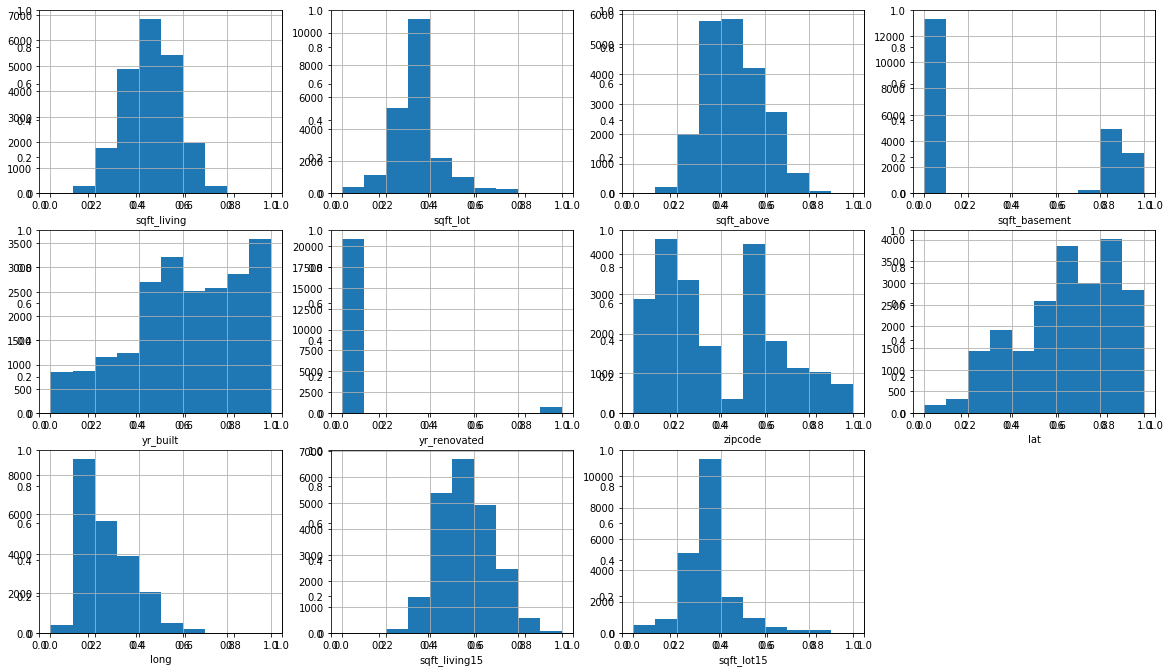

In [33]:
histograms(kchd_df, continuous_features);

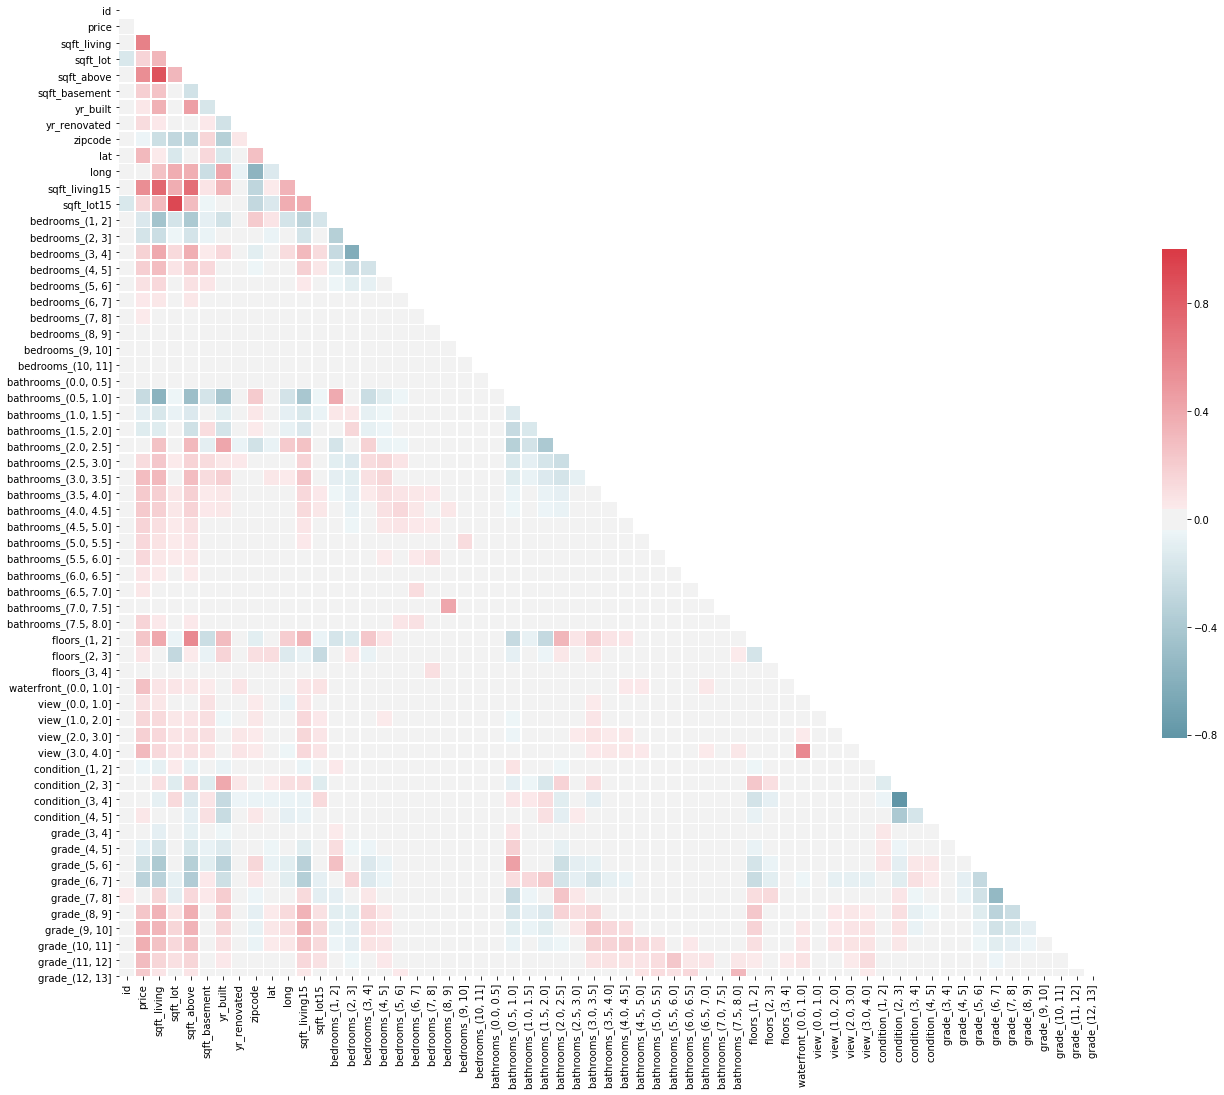

In [34]:
plot_corr(kchd_df)

## Linear Regression Feature Selection

In [35]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [41]:
kchd_renamed_cols_df = kchd_df.drop(['id', 'date'], axis=1)
kchd_renamed_cols_df = kchd_renamed_cols_df.rename(columns=lambda x: x.replace(" ", "").replace(",", "__").replace(".", "_").replace("(", "e").replace("]", "i"))
#print(kchd_renamed_cols_df.columns)

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'bedrooms_e1__2i', 'bedrooms_e2__3i', 'bedrooms_e3__4i',
       'bedrooms_e4__5i', 'bedrooms_e5__6i', 'bedrooms_e6__7i',
       'bedrooms_e7__8i', 'bedrooms_e8__9i', 'bedrooms_e9__10i',
       'bedrooms_e10__11i', 'bathrooms_e0_0__0_5i', 'bathrooms_e0_5__1_0i',
       'bathrooms_e1_0__1_5i', 'bathrooms_e1_5__2_0i', 'bathrooms_e2_0__2_5i',
       'bathrooms_e2_5__3_0i', 'bathrooms_e3_0__3_5i', 'bathrooms_e3_5__4_0i',
       'bathrooms_e4_0__4_5i', 'bathrooms_e4_5__5_0i', 'bathrooms_e5_0__5_5i',
       'bathrooms_e5_5__6_0i', 'bathrooms_e6_0__6_5i', 'bathrooms_e6_5__7_0i',
       'bathrooms_e7_0__7_5i', 'bathrooms_e7_5__8_0i', 'floors_e1__2i',
       'floors_e2__3i', 'floors_e3__4i', 'waterfront_e0_0__1_0i',
       'view_e0_0__1_0i', 'view_e1_0__2_0i', 'view_e2_0__3_0i',
       'view_e3_0__4_0i', 'condition_e1__2i', '

In [42]:
data_fin = kchd_renamed_cols_df.copy()
kchd_no_target_df = kchd_renamed_cols_df.drop([target], axis=1)
sig_features = stepwise_selection(kchd_no_target_df, data_fin[target], verbose = True)
print("\nresulting features:\n{}".format(sig_features))

Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  grade_e10__11i                 with p-value 0.0
Add  waterfront_e0_0__1_0i          with p-value 0.0
Add  lat                            with p-value 0.0
Add  grade_e11__12i                 with p-value 0.0
Add  grade_e9__10i                  with p-value 0.0
Add  grade_e12__13i                 with p-value 0.0
Add  grade_e8__9i                   with p-value 3.3621e-242
Add  yr_built                       with p-value 1.82852e-279
Add  grade_e7__8i                   with p-value 3.79139e-140
Add  bathrooms_e7_5__8_0i           with p-value 2.40184e-87
Add  view_e3_0__4_0i                with p-value 1.71099e-63
Add  view_e2_0__3_0i                with p-value 8.95289e-55
Add  zipcode                        with p-value 5.648e-41
Add  long                           with p-value 1.10793e-61
Add  condition_e4__5i               with p-value 2.27422e-40
Add  view_e1_0__2_0i       

In [43]:
f = target + '~' + "+".join(sig_features)
model_fit_results = ols(formula=f, data=data_fin).fit()
model_fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1534.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:57:53   Log-Likelihood:            -2.9304e+05
No. Observations:               21597   AIC:                         5.862e+05
Df Residuals:                   21557   BIC:                         5.865e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -8.445e+04    1.2e+04     -7.047      0.000   -1.08e+05    -6.1e+04
sqft_above             5.217e+05   4.16e+04     12.544      0.000     4.4e+05    6.03e+05
sqft_basement          6.753e+04   6473.732     10.431      0.000    5.48e+04    8.02e+04
grade_e10__11i         6.817e+05   1.33e+04     51.228      0.000    6.56e+05    7.08e+05
waterfront_e0_0__1_0i  5.776e+05   1.93e+04     29.983      0.000     5.4e+05    6.15e+05
lat                    3.682e+05   6354.644     57.944      0.000    3.56e+05    3.81e+05
grade_e11__12i         1.121e+06   2.34e+04     47.879      0.000    1.08e+06    1.17e+06
grade_e9__10i          4.288e+05   9620.624     44.575      0.000     4.1e+05    4.48e+05
grade_e12__13i         2.051e+06   5.82e+04     35.221      0.000    1.94e+06    2.17e+06
grade_e8__9i           2.502e+05   7790.121     32.120      0.000    2.35e+05    2.65e+05
yr_built              -2.308e+05   7453.633    -30.962      0.000   -2.45e+05   -2.16e+05
grade_e7__8i           1.062e+05   6200.995     17.126      0.000     9.4e+04    1.18e+05
bathrooms_e7_5__8_0i   2.791e+06   1.18e+05     23.724      0.000    2.56e+06    3.02e+06
view_e3_0__4_0i        2.526e+05   1.34e+04     18.857      0.000    2.26e+05    2.79e+05
view_e2_0__3_0i        1.413e+05   8836.824     15.990      0.000    1.24e+05    1.59e+05
zipcode               -1.186e+05   6177.375    -19.204      0.000   -1.31e+05   -1.07e+05
long                  -1.759e+05   1.52e+04    -11.579      0.000   -2.06e+05   -1.46e+05
condition_e4__5i       8.592e+04   5224.363     16.446      0.000    7.57e+04    9.62e+04
view_e1_0__2_0i        7.518e+04   6481.267     11.600      0.000    6.25e+04    8.79e+04
view_e0_0__1_0i        1.208e+05   1.07e+04     11.322      0.000    9.99e+04    1.42e+05
sqft_lot15            -1.906e+05   1.41e+04    -13.540      0.000   -2.18e+05   -1.63e+05
bathrooms_e4_5__5_0i   5.073e+05   2.96e+04     17.137      0.000    4.49e+05    5.65e+05
bathrooms_e4_0__4_5i   2.767e+05   1.53e+04     18.071      0.000    2.47e+05    3.07e+05
sqft_living15          2.752e+05   1.86e+04     14.834      0.000    2.39e+05    3.12e+05
bathrooms_e5_5__6_0i   9.486e+05   6.24e+04     15.191      0.000    8.26e+05    1.07e+06
bathrooms_e3_5__4_0i       2e+05    1.2e+04     16.687      0.000    1.76e+05    2.23e+05
bathrooms_e5_0__5_5i   6.284e+05   4.07e+04     15.424      0.000    5.49e+05    7.08e+05
bathrooms_e3_0__3_5i   9.176e+04   6204.758     14.789      0.000    7.96e+04    1.04e+05
yr_renovated           8.049e+04   7532.381     10.686      0.000    6.57e+04    9.53e+04
condition_e3__4i       3.519e+04   3272.166     10.755      0.000    2.88e+04    4.16e+04
grade_e6__7i            3.61e+04   5041.548      7.160      0.000    2.62e+04     4.6e+04
floors_e2__3i          

In [44]:
tf = [target]
kchd_renamed_cols_with_lt_scaled_target_df = min_max_scaling(log_transform(kchd_renamed_cols_df, tf), tf)
data_fin = kchd_renamed_cols_with_lt_scaled_target_df.copy()
kchd_no_target_with_lt_scaled_target_df = kchd_renamed_cols_with_lt_scaled_target_df.drop([target], axis=1)
sig_features = stepwise_selection(kchd_no_target_with_lt_scaled_target_df, data_fin[target], verbose = True)
print("\nresulting features:\n{}".format(sig_features))

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Add  grade_e8__9i                   with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  waterfront_e0_0__1_0i          with p-value 2.06857e-196
Add  grade_e9__10i                  with p-value 1.82048e-159
Add  grade_e10__11i                 with p-value 2.50416e-190
Add  grade_e7__8i                   with p-value 1.08946e-208
Add  grade_e11__12i                 with p-value 2.66597e-198
Add  grade_e6__7i                   with p-value 1.31075e-121
Add  grade_e12__13i                 with p-value 6.953

In [45]:
f = target + '~' + "+".join(sig_features)
model_fit_results = ols(formula=f, data=data_fin).fit()
model_fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1787.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        00:18:16   Log-Likelihood:                 32327.
No. Observations:               21597   AIC:                        -6.457e+04
Df Residuals:                   21554   BIC:                        -6.423e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0228      0.006      3.754      0.000       0.011       0.035
grade_e8__9i              0.1347      0.004     33.539      0.000       0.127       0.143
sqft_above                0.0992      0.013      7.815      0.000       0.074       0.124
sqft_basement             0.0166      0.002      8.905      0.000       0.013       0.020
yr_built                 -0.0830      0.002    -36.926      0.000      -0.087      -0.079
lat                       0.1847      0.002    101.269      0.000       0.181       0.188
sqft_living15             0.1267      0.005     23.760      0.000       0.116       0.137
waterfront_e0_0__1_0i     0.0888      0.006     16.104      0.000       0.078       0.100
grade_e9__10i             0.1668      0.004     38.383      0.000       0.158       0.175
grade_e10__11i            0.1959      0.005     38.509      0.000       0.186       0.206
grade_e7__8i              0.0927      0.004     24.631      0.000       0.085       0.100
grade_e11__12i            0.2382      0.007     31.856      0.000       0.224       0.253
grade_e6__7i              0.0583      0.004     16.317      0.000       0.051       0.065
grade_e12__13i            0.3049      0.016     19.033      0.000       0.274       0.336
condition_e4__5i          0.0537      0.004     13.016      0.000       0.046       0.062
sqft_lot15               -0.0690      0.008     -8.160      0.000      -0.086      -0.052
condition_e3__4i          0.0386      0.004      9.736      0.000       0.031       0.046
view_e2_0__3_0i           0.0409      0.003     16.157      0.000       0.036       0.046
view_e3_0__4_0i           0.0583      0.004     15.207      0.000       0.051       0.066
view_e1_0__2_0i           0.0270      0.002     14.540      0.000       0.023       0.031
zipcode                  -0.0285      0.002    -16.024      0.000      -0.032      -0.025
view_e0_0__1_0i           0.0363      0.003     11.866      0.000       0.030       0.042
sqft_living               0.1689      0.014     11.876      0.000       0.141       0.197
yr_renovated              0.0177      0.002      8.139      0.000       0.013       0.022
bedrooms_e1__2i           0.0163      0.001     10.967      0.000       0.013       0.019
bathrooms_e3_0__3_5i      0.0213      0.002     11.938      0.000       0.018       0.025
floors_e2__3i             0.0246      0.002     10.349      0.000       0.020       0.029
floors_e1__2i             0.0108      0.001     10.199      0.000       0.009       0.013
grade_e5__6i              0.0262      0.004      7.332      0.000       0.019       0.033
bathrooms_e3_5__4_0i      0.0351      0.003     10.235      0.000       0.028       0.042
condition_e2__3i          0.0264      0.004      6.683      0.000       0.019       0.034
bathrooms_e4_0__4_5i   

In [46]:
sorted(sig_features)

['bathrooms_e0_5__1_0i',
 'bathrooms_e1_0__1_5i',
 'bathrooms_e2_5__3_0i',
 'bathrooms_e3_0__3_5i',
 'bathrooms_e3_5__4_0i',
 'bathrooms_e4_0__4_5i',
 'bathrooms_e4_5__5_0i',
 'bathrooms_e5_0__5_5i',
 'bathrooms_e5_5__6_0i',
 'bedrooms_e1__2i',
 'bedrooms_e2__3i',
 'bedrooms_e5__6i',
 'bedrooms_e6__7i',
 'condition_e2__3i',
 'condition_e3__4i',
 'condition_e4__5i',
 'floors_e1__2i',
 'floors_e2__3i',
 'grade_e10__11i',
 'grade_e11__12i',
 'grade_e12__13i',
 'grade_e5__6i',
 'grade_e6__7i',
 'grade_e7__8i',
 'grade_e8__9i',
 'grade_e9__10i',
 'lat',
 'long',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view_e0_0__1_0i',
 'view_e1_0__2_0i',
 'view_e2_0__3_0i',
 'view_e3_0__4_0i',
 'waterfront_e0_0__1_0i',
 'yr_built',
 'yr_renovated',
 'zipcode']

# References

Pawan, S. (2017). Predicting King County House Prices. Presentation, https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices.